In [1]:
import sys
import os
# Add parent directory to path to import utils
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
results_folder="results/rand_cliffs_auto"


ERROR VALUES AND DIFFERENCES BY CIRCUIT SIZE
PCE Method: EXPONENTIAL
--------------------------------------------------------------------------------

6 QUBITS:
Depth      PCE Error       Best ZNE Error  Difference      Winner    
----------------------------------------------------------------------
20         0.033370        0.012861              -0.020509 ZNE       
25         0.030410        0.016860              -0.013551 ZNE       
30         0.031094        0.017881              -0.013213 ZNE       
35         0.037527        0.032558              -0.004969 ZNE       
40         0.034930        0.022140              -0.012790 ZNE       
45         0.044292        0.034194              -0.010098 ZNE       
50         0.059234        0.047632              -0.011602 ZNE       
55         0.045845        0.043052              -0.002793 ZNE       
60         0.042775        0.048148              +0.005372 PCE       

8 QUBITS:
Depth      PCE Error       Best ZNE Error  Difference   

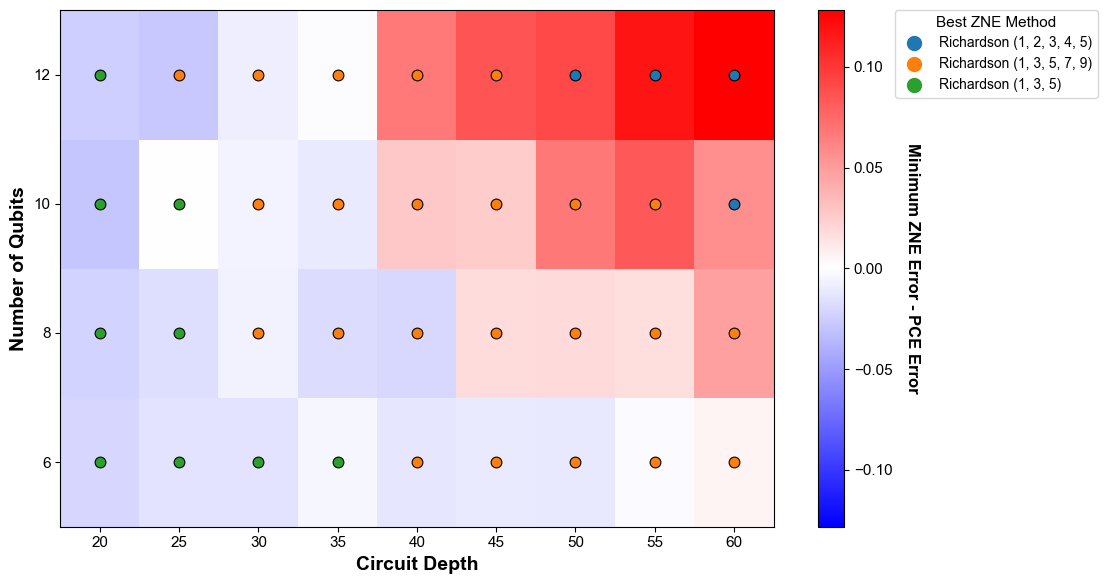

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils.pce_vs_zne_utils import load_avg_errors

# Set publication-ready font and sizes globally
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'mathtext.fontset': 'custom',
    'mathtext.sf': 'Arial',  # For consistent math fonts
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

def format_zne_method_label(method_key):
    """
    Format ZNE method labels professionally for legend display.
    E.g., "richardson_1_3_5_7_9" -> "Richardson (1, 3, 5, 7, 9)"
    """
    # Remove zne_ prefix and _fold/_global suffixes
    label = (method_key
            .replace("zne_", "")
            .replace("_fold", "")
            .replace("_global", ""))

    # Split into parts
    parts = label.split("_")
    if len(parts) == 0:
        return label.title()

    # First part is the method name
    method_name = parts[0].title()

    # Check if remaining parts are numbers (scale factors)
    remaining_parts = parts[1:]
    if remaining_parts and all(part.replace(".", "").isdigit() for part in remaining_parts):
        # Format as "Method (factor1, factor2, ...)"
        factors = ", ".join(remaining_parts)
        return f"{method_name} ({factors})"
    else:
        # Just replace underscores with spaces and capitalize
        return " ".join([method_name] + [p.title() for p in remaining_parts])

def plot_pce_vs_zne_heatmap(
    results_folder: str,
    qubit_list: list,
    depth_list: list,
    num_circs: int,
    num_samples: int,
    pce_method: str
):
    """
    Heatmap of (Best ZNE_error – PCE_error). Positive ⇒ PCE wins.
    Each cell is marked with a dot colored by which ZNE method was best.
    """
    nq, nd = len(qubit_list), len(depth_list)
    diff_mat = np.zeros((nq, nd))
    best_zne_key = [["" for _ in range(nd)] for _ in range(nq)]

    # Store actual error values for printing
    pce_errors = np.zeros((nq, nd))
    best_zne_errors = np.zeros((nq, nd))

    # 1) Build the diff matrix and record the best ZNE key for every cell
    for j, depth in enumerate(depth_list):
        data = load_avg_errors(
            results_folder,
            num_circs=num_circs,
            num_samples=num_samples,
            depth=depth
        )
        for i, q in enumerate(qubit_list):
            errs    = data.get(q, {})
            pce_err = errs.get(f"pce_{pce_method}", np.nan)
            pce_errors[i, j] = pce_err

            zne_items = [(k, v) for k, v in errs.items() if k.startswith("zne_")]
            if zne_items:
                zk, zv = min(zne_items, key=lambda kv: kv[1])
            else:
                zk, zv = None, np.nan

            best_zne_errors[i, j] = zv

            # lowest ZNE minus PCE, so positive means PCE had the lower error
            diff_mat[i, j] = zv - pce_err

            # record which ZNE variant was best (if any)
            if zk:
                best_zne_key[i][j] = zk

    # Print error values and differences
    print("\n" + "="*80)
    print("ERROR VALUES AND DIFFERENCES BY CIRCUIT SIZE")
    print("="*80)
    print(f"PCE Method: {pce_method.upper()}")
    print("-"*80)

    for i, q in enumerate(qubit_list):
        print(f"\n{q} QUBITS:")
        print(f"{'Depth':<10} {'PCE Error':<15} {'Best ZNE Error':<15} {'Difference':<15} {'Winner':<10}")
        print("-"*70)

        for j, depth in enumerate(depth_list):
            pce_val = pce_errors[i, j]
            zne_val = best_zne_errors[i, j]
            diff = diff_mat[i, j]
            winner = "PCE" if diff > 0 else "ZNE" if diff < 0 else "Tie"

            if not np.isnan(pce_val) and not np.isnan(zne_val):
                print(f"{depth:<10} {pce_val:<15.6f} {zne_val:<15.6f} {diff:+15.6f} {winner:<10}")
            else:
                print(f"{depth:<10} {'NaN':<15} {'NaN':<15} {'NaN':<15} {'N/A':<10}")

    # Print summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)

    valid_diffs = diff_mat[~np.isnan(diff_mat)]
    if len(valid_diffs) > 0:
        pce_wins = np.sum(valid_diffs > 0)
        zne_wins = np.sum(valid_diffs < 0)
        ties = np.sum(valid_diffs == 0)

        print(f"PCE wins: {pce_wins}/{len(valid_diffs)} ({100*pce_wins/len(valid_diffs):.1f}%)")
        print(f"ZNE wins: {zne_wins}/{len(valid_diffs)} ({100*zne_wins/len(valid_diffs):.1f}%)")
        print(f"Ties: {ties}/{len(valid_diffs)} ({100*ties/len(valid_diffs):.1f}%)")
        print(f"\nMean difference (positive favors PCE): {np.mean(valid_diffs):+.6f}")
        print(f"Median difference: {np.median(valid_diffs):+.6f}")
        print(f"Max PCE advantage: {np.max(valid_diffs):+.6f}")
        print(f"Max ZNE advantage: {np.min(valid_diffs):+.6f}")
    print("="*80 + "\n")

    # 2) Choose distinct colors for each ZNE variant
    winners = sorted({k for row in best_zne_key for k in row if k})
    cmap    = plt.get_cmap("tab10")
    colors  = {k: cmap(idx) for idx, k in enumerate(winners)}

    # 3) Plot heatmap with better proportions
    fig, ax = plt.subplots(figsize=(12, 6))  # Made wider for better proportions
    im = ax.imshow(
        diff_mat, aspect='auto', origin='lower',
        cmap='bwr',
        vmin=-np.nanmax(np.abs(diff_mat)),
        vmax= np.nanmax(np.abs(diff_mat))
    )

    # Axes with improved formatting - bold labels
    ax.set_xticks(np.arange(nd))
    ax.set_xticklabels(depth_list)
    ax.set_yticks(np.arange(nq))
    ax.set_yticklabels(qubit_list)
    ax.set_xlabel("Circuit Depth", fontsize=14, fontweight='bold')
    ax.set_ylabel("Number of Qubits", fontsize=14, fontweight='bold')

    # Colorbar with the error difference label
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Minimum ZNE Error - PCE Error", fontsize=12, labelpad=20, rotation=270, fontweight='bold')
    cbar.ax.tick_params(labelsize=11)

    # 4) Drop in method-colored dots for best ZNE variant in each cell
    for i in range(nq):
        for j in range(nd):
            zk = best_zne_key[i][j]
            if zk:
                ax.scatter(
                    j, i,
                    marker='o',
                    s=60,  # Slightly larger dots
                    color=colors[zk],
                    edgecolor='k',
                    linewidth=0.8,  # Thicker edge
                    zorder=3
                )

    # 5) Legend for best ZNE variants with improved formatting
    handles = []
    for k in winners:
        label = format_zne_method_label(k)
        handles.append(
            plt.Line2D(
                [], [], marker='o',
                color=colors[k],
                linestyle='None',
                markersize=10,  # Larger legend markers
                label=label
            )
        )

    ax.legend(
        handles=handles,
        title="Best ZNE Method",
        title_fontsize=11,
        fontsize=10,
        bbox_to_anchor=(1.17, 1),   # Moved closer to the plot
        loc="upper left",
        borderaxespad=0
    )

    # 6) Tidy layout & reserve space on the right for the legend
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)  # Adjusted for wider figure

    plt.savefig("heatmap-50_000_samples.pdf", dpi=300, bbox_inches='tight')  # High DPI for publication

    plt.show()


# Example usage:
qubit_list = [6, 8, 10, 12]
depth_list = range(20, 61, 5)
plot_pce_vs_zne_heatmap(
    results_folder=results_folder,
    qubit_list=qubit_list,
    depth_list=depth_list,
    num_circs=20,
    num_samples=50_000,
    pce_method="exponential"
)

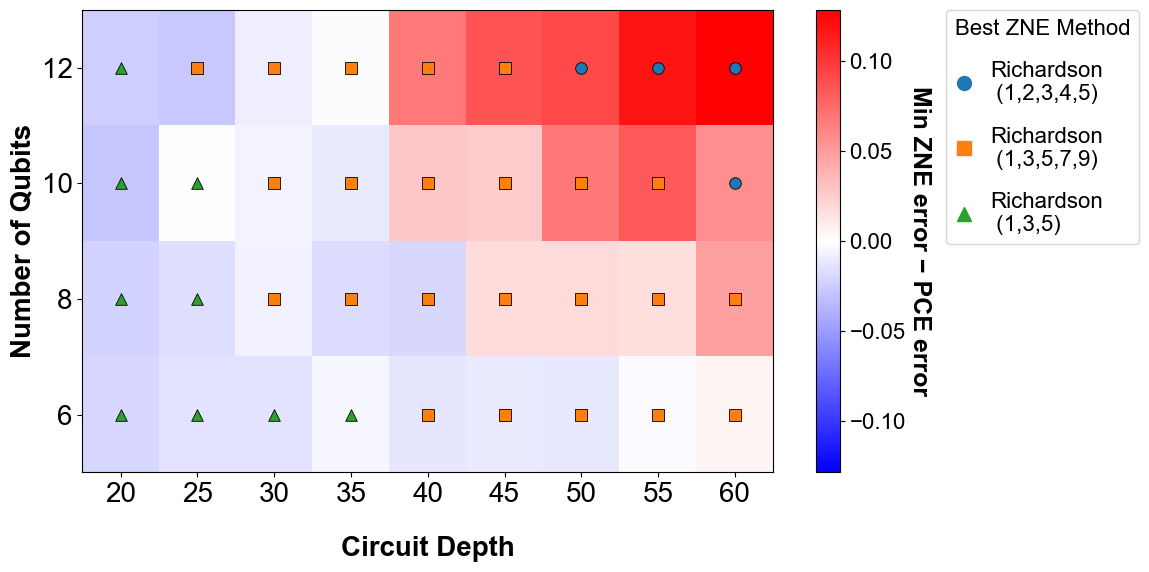

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from utils.pce_vs_zne_utils import load_avg_errors

# Light styling (no LaTeX)
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 16,
})

def format_zne_method_label(method_key: str) -> str:
    label = (method_key.replace("zne_", "").replace("_fold", "").replace("_global", ""))
    parts = label.split("_")
    if not parts:
        return label.title()
    name, rest = parts[0].title(), parts[1:]
    if rest and all(p.replace(".", "").isdigit() for p in rest):
        return f"{name}\n ({','.join(rest)})"
    return " ".join([name] + [p.title() for p in rest])

def plot_pce_vs_zne_heatmap(
    results_folder: str,
    qubit_list: list,
    depth_list: list,
    num_circs: int,
    num_samples: int,
    pce_method: str
):
    nq, nd = len(qubit_list), len(depth_list)
    diff_mat = np.full((nq, nd), np.nan)
    best_zne_key = [["" for _ in range(nd)] for _ in range(nq)]

    # Load errors and compute Best ZNE − PCE per cell
    for j, depth in enumerate(depth_list):
        data = load_avg_errors(results_folder, num_circs=num_circs, num_samples=num_samples, depth=depth)
        for i, q in enumerate(qubit_list):
            errs = data.get(q, {})
            pce_err = errs.get(f"pce_{pce_method}", np.nan)
            zne_items = [(k, v) for k, v in errs.items() if k.startswith("zne_")]
            if zne_items:
                zk, zv = min(zne_items, key=lambda kv: kv[1])
                best_zne_key[i][j] = zk
            else:
                zv = np.nan
            diff_mat[i, j] = zv - pce_err

    winners = sorted({k for row in best_zne_key for k in row if k})
    cmap = plt.get_cmap("tab10")
    colors = {k: cmap(idx) for idx, k in enumerate(winners)}

    fig, ax = plt.subplots(figsize=(12, 6))
    vmax = np.nanmax(np.abs(diff_mat)) if np.isfinite(diff_mat).any() else 1.0
    im = ax.imshow(diff_mat, aspect='auto', origin='lower', cmap='bwr', vmin=-vmax, vmax=vmax)

    ax.set_xticks(np.arange(nd)); ax.set_xticklabels(depth_list)
    ax.set_yticks(np.arange(nq)); ax.set_yticklabels(qubit_list)
    ax.set_xlabel("Circuit Depth", fontweight='bold', labelpad=20)
    ax.set_ylabel("Number of Qubits", fontweight='bold')

    # Plain-words colorbar label (no mathtext/LaTeX)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Min ZNE error − PCE error", fontsize=18, labelpad=18, rotation=270, fontweight='bold')
    cbar.ax.tick_params(labelsize=16)

    # Markers for best ZNE method
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']
    for i in range(nq):
        for j in range(nd):
            zk = best_zne_key[i][j]
            if zk:
                idx = winners.index(zk) % len(markers)
                ax.scatter(j, i, marker=markers[idx], s=70, color=colors[zk],
                           edgecolor='k', linewidth=0.6, zorder=3)

    if winners:
        handles = [
            plt.Line2D([], [], marker=markers[idx % len(markers)],
                       color=colors[k], linestyle='None', markersize=10,
                       label=format_zne_method_label(k))
            for idx, k in enumerate(winners)
        ]
        leg = ax.legend(
                handles=handles,
                title="Best ZNE Method",
                bbox_to_anchor=(1.25, 1),
                loc="upper left",
                borderaxespad=0,
                labelspacing=1.0,     # keep your vertical spacing
                handletextpad=0.8,    # ↓ closer text to marker (default ~0.8–0.9)
                handlelength=0.8      # optional: shorter marker so text sits nearer
            )
        leg._legend_box.align = "left"

    plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    plt.savefig("heatmap-50_000_samples.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Use your already-defined 'results_folder' variable from earlier in the notebook:
qubit_list = [6, 8, 10, 12]
depth_list = list(range(20, 61, 5))
plot_pce_vs_zne_heatmap(
    results_folder=results_folder,
    qubit_list=qubit_list,
    depth_list=depth_list,
    num_circs=20,
    num_samples=50_000,
    pce_method="exponential"
)




In [ ]:
import matplotlib.pyplot as plt

plt.title(r'This is a title with $\alpha^2$')
plt.show()


In [6]:
# import numpy as np
# import matplotlib.pyplot as plt
# from utils.pce_vs_zne_utils import load_avg_errors

# def plot_pce_vs_zne_heatmap(
#     results_folder: str,
#     qubit_list: list,
#     depth_list: list,
#     num_circs: int,
#     num_samples: int,
#     pce_method: str
# ):
#     """
#     Heatmap of (Best ZNE_error – PCE_error). Positive ⇒ PCE wins.
#     Each cell is marked with:
#       • if any ZNE beats PCE (zv < pce_err): side-by-side dots for all those ZNEs,
#         sized by rank (largest = best).
#       • otherwise (PCE wins): a single dot (centered) for the best ZNE.
#     """
#     nq, nd = len(qubit_list), len(depth_list)

#     # 1) load errors & build matrices
#     diff_mat     = np.zeros((nq, nd))
#     pce_err_mat  = np.zeros((nq, nd))
#     zne_rankings = [[[] for _ in range(nd)] for _ in range(nq)]

#     for j, depth in enumerate(depth_list):
#         data = load_avg_errors(
#             results_folder,
#             num_circs=num_circs,
#             num_samples=num_samples,
#             depth=depth
#         )
#         for i, q in enumerate(qubit_list):
#             errs    = data.get(q, {})
#             pce_err = errs.get(f"pce_{pce_method}", np.nan)
#             pce_err_mat[i, j] = pce_err

#             # all ZNE variants sorted by ascending error
#             zne_items  = [(k, v) for k, v in errs.items() if k.startswith("zne_")]
#             zne_sorted = sorted(zne_items, key=lambda kv: kv[1])
#             zne_rankings[i][j] = zne_sorted

#             # best-ZNE minus PCE (for heatmap)
#             best_zv        = zne_sorted[0][1] if zne_sorted else np.nan
#             diff_mat[i, j] = best_zv - pce_err

#     # 2) prepare colors & legend entries
#     all_zne_methods = sorted({
#         k for row in zne_rankings for cell in row for k, _ in cell
#     })
#     cmap   = plt.get_cmap("tab10")
#     colors = {k: cmap(idx) for idx, k in enumerate(all_zne_methods)}

#     # 3) draw heatmap
#     fig, ax = plt.subplots(figsize=(1.5 * nd, 1.2 * nq))
#     im = ax.imshow(
#         diff_mat, aspect='auto', origin='lower',
#         cmap='bwr',
#         vmin=-np.nanmax(np.abs(diff_mat)),
#         vmax= np.nanmax(np.abs(diff_mat))
#     )

#     ax.set_xticks(np.arange(nd));    ax.set_xticklabels(depth_list)
#     ax.set_yticks(np.arange(nq));    ax.set_yticklabels(qubit_list)
#     ax.set_xlabel("Circuit Depth")
#     ax.set_ylabel("Number of Qubits")
#     ax.set_title(f"Best ZNE – PCE({pce_method}), samples={num_samples}")

#     cbar = fig.colorbar(im, ax=ax)
#     cbar.set_label("Best ZNE_error − PCE_error")

#     # 4) overlay dots
#     for i in range(nq):
#         for j in range(nd):
#             pce_err = pce_err_mat[i, j]
#             znes    = zne_rankings[i][j]
#             winners = [(k, v) for (k, v) in znes if v < pce_err]

#             if winners:
#                 n       = len(winners)
#                 offsets = (np.arange(n) - (n - 1)/2) * 0.2
#                 sizes   = np.linspace(100, 30, n)
#                 for (k, _), off, sz in zip(winners, offsets, sizes):
#                     ax.scatter(
#                         j + off, i,
#                         marker='o',
#                         s=sz,
#                         color=colors[k],
#                         edgecolor='k',
#                         linewidth=0.5,
#                         zorder=3
#                     )
#             else:
#                 if znes:
#                     k_best = znes[0][0]
#                     ax.scatter(
#                         j, i,
#                         marker='o',
#                         s=80,
#                         color=colors[k_best],
#                         edgecolor='k',
#                         linewidth=0.5,
#                         zorder=3
#                     )

#     # 5) legend for ZNE methods, stripping unwanted substrings
#     handles = []
#     for k in all_zne_methods:
#         label = k.replace("zne_", "").replace("_fold", "").replace("_global", "")
#         handles.append(
#             plt.Line2D(
#                 [], [], marker='o',
#                 color=colors[k],
#                 linestyle='None',
#                 markersize=8,
#                 label=label
#             )
#         )

#     # move legend further right without shrinking heatmap
#     ax.legend(
#         handles=handles,
#         title="ZNE methods",
#         bbox_to_anchor=(1.3, 1),  # shift legend farther right
#         loc="upper left",
#         borderaxespad=0
#     )

#     # 6) layout and reserve same heatmap width but more room
#     plt.tight_layout()
#     fig.subplots_adjust(right=0.7)  # push axes to 70%, leaving 30% for legend

#     plt.show()


# # Example usage:
# qubit_list = [6, 8, 10, 12]
# depth_list = range(20, 61, 20)
# plot_pce_vs_zne_heatmap(
#     results_folder="data_PCE_vs_ZNE/rand_cliffs_auto",
#     qubit_list=qubit_list,
#     depth_list=depth_list,
#     num_circs=20,
#     num_samples=50_000,
#     pce_method="exponential"
# )






In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils.pce_vs_zne_utils import load_avg_errors

def plot_error_bars(
    results_folder: str,
    qubit_list: list,
    depth: int,
    num_circs: int,
    num_samples: int,
    pce_methods: list[str],
    top_k_zne: int = 3
):
    """
    Bar plot of absolute error for specified PCE methods and the top-K ZNE methods,
    with value labels on top of each bar (vertical orientation).
    
    Parameters
    ----------
    results_folder : str
        Path to your results.
    qubit_list : list of int
        Which qubit counts to include on the x-axis.
    depth : int
        Circuit depth to load.
    num_circs : int
        Number of random circuits used.
    num_samples : int
        Number of measurement samples.
    pce_methods : list of str
        List of PCE method suffixes, e.g. ["linear","exponential"].
    top_k_zne : int
        How many of the best-performing ZNE methods to include.
    """
    # 1) load all errors for this depth
    data = load_avg_errors(
        results_folder,
        num_circs=num_circs,
        num_samples=num_samples,
        depth=depth
    )

    # 2) pick top-K ZNE by average error across qubit_list
    all_zne_keys = sorted({k for errs in data.values() for k in errs if k.startswith("zne_")})
    mean_zne = {k: np.nanmean([data.get(q, {}).get(k, np.nan) for q in qubit_list])
                for k in all_zne_keys}
    top_zne_keys = sorted(mean_zne, key=lambda k: mean_zne[k])[:top_k_zne]

    # 3) assemble method keys and labels
    pce_keys    = [f"pce_{m}" for m in pce_methods]
    method_keys = pce_keys + top_zne_keys
    labels      = [key.split("_", 1)[1] for key in method_keys]

    # 4) build error matrix [n_methods x n_qubits]
    err_mat = np.zeros((len(method_keys), len(qubit_list)))
    for mi, key in enumerate(method_keys):
        for qi, q in enumerate(qubit_list):
            err_mat[mi, qi] = data.get(q, {}).get(key, np.nan)

    # 5) plot bars with labels
    x     = np.arange(len(qubit_list))
    nmet  = len(method_keys)
    width = 0.8 / nmet

    fig, ax = plt.subplots(figsize=(1.2 * nmet * len(qubit_list), 6))
    for mi in range(nmet):
        rects = ax.bar(
            x + mi * width,
            np.abs(err_mat[mi]),    # absolute error
            width=width,
            label=labels[mi]
        )
        # annotate each bar with its height
        for rect in rects:
            h = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                h,
                f"{h:.2f}",
                ha='center',
                va='bottom',
                rotation=90
            )

    # 6) labels, legend, styling
    ax.set_xticks(x + width * (nmet - 1) / 2)
    ax.set_xticklabels(qubit_list)
    ax.set_xlabel("Number of Qubits")
    ax.set_ylabel("Absolute Error")
    ax.set_title(f"Depth={depth}, {num_circs} circuits, {num_samples} samples")
    ax.legend(
        title="Method",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0
    )

    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    plt.show()


# Example usage:
qubit_list  = [6, 8, 10, 12]
plot_error_bars(
    results_folder=results_folder,
    qubit_list=qubit_list,
    depth=60,
    num_circs=20,
    num_samples=50_000,
    pce_methods=["exponential"],
    top_k_zne=3
)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils.pce_vs_zne_utils import load_avg_errors

def plot_error_bars_vs_depth(
    results_folder: str,
    qubit: int,
    depth_list: list,
    num_circs: int,
    num_samples: int,
    pce_methods: list[str],
    top_k_zne: int = 3
):
    """
    Bar plot of absolute error vs. circuit depth for a fixed qubit count.
    Compares specified PCE methods and the top-K ZNE methods, with value labels
    on top of each bar (vertical text orientation).

    Parameters
    ----------
    results_folder : str
        Path to your results (CSV files).
    qubit : int
        Fixed number of qubits to plot.
    depth_list : list of int
        Circuit depths to include on the x-axis.
    num_circs : int
        Number of random circuits used.
    num_samples : int
        Number of measurement samples.
    pce_methods : list of str
        List of PCE method suffixes, e.g. ["linear","exponential"].
    top_k_zne : int
        How many of the best-performing ZNE methods to include.
    """
    # 1) load errors for each depth
    data_by_depth = {}
    for depth in depth_list:
        all_data = load_avg_errors(
            results_folder,
            num_circs=num_circs,
            num_samples=num_samples,
            depth=depth
        )
        data_by_depth[depth] = all_data.get(qubit, {})

    # 2) determine top-K ZNE by mean error across depths
    all_zne_keys = sorted({
        k for errs in data_by_depth.values() for k in errs if k.startswith("zne_")
    })
    mean_zne = {
        k: np.nanmean([data_by_depth[d].get(k, np.nan) for d in depth_list])
        for k in all_zne_keys
    }
    top_zne_keys = sorted(mean_zne, key=lambda k: mean_zne[k])[:top_k_zne]

    # 3) assemble method keys and labels
    pce_keys    = [f"pce_{m}" for m in pce_methods]
    method_keys = pce_keys + top_zne_keys
    labels      = [key.split("_", 1)[1] for key in method_keys]

    # 4) build error matrix [n_methods x n_depths]
    err_mat = np.zeros((len(method_keys), len(depth_list)))
    for mi, key in enumerate(method_keys):
        for di, depth in enumerate(depth_list):
            err_mat[mi, di] = data_by_depth[depth].get(key, np.nan)

    # 5) plot bars with value annotations
    x    = np.arange(len(depth_list))
    nmet = len(method_keys)
    width = 0.8 / nmet

    # Increased height from 6 to 8
    fig, ax = plt.subplots(figsize=(1.2 * nmet * len(depth_list), 8))
    for mi in range(nmet):
        rects = ax.bar(
            x + mi * width,
            np.abs(err_mat[mi]),
            width=width,
            label=labels[mi]
        )
        for rect in rects:
            h = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                h,
                f"{h:.2f}",
                ha='center',
                va='bottom',
                rotation=90
            )

    # 6) labels, legend, styling
    ax.set_xticks(x + width * (nmet - 1) / 2)
    ax.set_xticklabels(depth_list)
    ax.set_xlabel("Circuit Depth")
    ax.set_ylabel("Absolute Error")
    ax.set_title(f"Qubits={qubit}, {num_circs} circuits, {num_samples} samples")

    # Added extra top margin with ylim adjustment
    ax.set_ylim(top=ax.get_ylim()[1] * 1.15)

    ax.legend(
        title="Method",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0
    )

    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    plt.show()

# Example usage:
plot_error_bars_vs_depth(
    results_folder=results_folder,
    qubit=12,
    depth_list=list(range(30, 61, 10)),
    num_circs=20,
    num_samples=50_000,
    pce_methods=["exponential"],
    top_k_zne=3
)

In [ ]:
import os
import re
import csv
import numpy as np
import matplotlib.pyplot as plt

def plot_error_lines_vs_cx_all_qubits(
    results_folder: str,
    num_circs: int,
    num_samples: int,
    pce_methods: list[str],
    top_k_zne: int = 3
):
    """
    Line plot of absolute error vs. number of CX gates, aggregated across all qubit counts.
    One line per method (specified PCE methods + top-K ZNE variants).

    Parameters
    ----------
    results_folder : str
        Folder containing CSV results named like:
        avg_errors_n=<n>_..._num_circs=<num_circs>_num_samp=<num_samples>..._cx=<cx>.csv
    num_circs : int
        Number of circuits used (embedded in filenames).
    num_samples : int
        Number of samples used (embedded in filenames).
    pce_methods : list of str
        List of PCE method suffixes, e.g. ["linear","exponential"].
    top_k_zne : int
        How many of the best-performing ZNE methods to include.
    """
    # 1) scan folder, load errors per CX value across qubit counts
    pattern = re.compile(
        rf"avg_errors_n=\d+.*num_circs={num_circs}.*num_samp={num_samples}.*_cx=(\d+\.?\d*)\.csv$"
    )
    temp = {}  # cx_val -> list of error dicts
    for fname in os.listdir(results_folder):
        m = pattern.search(fname)
        if not m:
            continue
        cx_val = float(m.group(1))
        path = os.path.join(results_folder, fname)
        with open(path, mode='r', newline='') as f:
            reader = csv.reader(f)
            next(reader)  # skip header
            err = {method.lower(): float(val) for method, val in reader}
        temp.setdefault(cx_val, []).append(err)

    cx_list = sorted(temp.keys())

    # 2) aggregate errors by CX: mean across all qubit counts
    combined = {}  # cx_val -> {method: mean_error}
    all_methods = set()
    for cx, dicts in temp.items():
        # collect all method keys
        for d in dicts:
            all_methods.update(d.keys())
    for cx in cx_list:
        combined[cx] = {}
        for method in all_methods:
            values = [d.get(method, np.nan) for d in temp[cx]]
            combined[cx][method] = float(np.nanmean(values))

    # 3) pick top-K ZNE by average across CX values
    zne_methods = sorted([m for m in all_methods if m.startswith('zne_')])
    mean_zne = {m: np.nanmean([combined[cx].get(m, np.nan) for cx in cx_list])
                for m in zne_methods}
    top_zne = sorted(mean_zne, key=lambda k: mean_zne[k])[:top_k_zne]

    # 4) assemble plotting keys and labels
    pce_keys = [f'pce_{m}' for m in pce_methods]
    plot_keys = pce_keys + top_zne
    labels = [k.split('_',1)[1] for k in plot_keys]

    # 5) build matrix of absolute errors
    err_mat = np.zeros((len(plot_keys), len(cx_list)))
    for i, key in enumerate(plot_keys):
        for j, cx in enumerate(cx_list):
            err_mat[i, j] = abs(combined[cx].get(key, np.nan))

    # 6) line plot
    fig, ax = plt.subplots(figsize=(1.2 * len(cx_list), 6))
    for i, label in enumerate(labels):
        ax.plot(
            cx_list,
            err_mat[i],
            marker='o',
            label=label
        )

    ax.set_xlabel('Number of CX gates')
    ax.set_ylabel('Absolute Error')
    ax.set_title(f'Errors vs CX count (avg over qubit counts); {num_circs} circuits, {num_samples} samples')
    ax.legend(title='Method', bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    plt.show()

# Example usage:
plot_error_lines_vs_cx_all_qubits(
    results_folder=results_folder,
    num_circs=20,
    num_samples=70_000,
    pce_methods=['exponential'],
    top_k_zne=3
)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils.pce_vs_zne_utils import load_avg_errors

def plot_pce_error_heatmap(
    results_folder: str,
    qubit_list: list,
    depth_list: list,
    num_circs: int,
    num_samples: int,
    pce_method: str
):
    """
    Heatmap of PCE_error for the specified method.
    """
    nq, nd = len(qubit_list), len(depth_list)
    pce_err_mat = np.zeros((nq, nd))

    # 1) Load PCE errors into a matrix
    for j, depth in enumerate(depth_list):
        data = load_avg_errors(
            results_folder,
            num_circs=num_circs,
            num_samples=num_samples,
            depth=depth
        )
        print(data)
        for i, q in enumerate(qubit_list):
            errs = data.get(q, {})
            pce_err_mat[i, j] = errs.get(f"pce_{pce_method}", np.nan)

    # 2) Plot heatmap
    fig, ax = plt.subplots(figsize=(1.5 * nd, 1.2 * nq))
    im = ax.imshow(
        pce_err_mat,
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )

    # Axes
    ax.set_xticks(np.arange(nd))
    ax.set_xticklabels(depth_list)
    ax.set_yticks(np.arange(nq))
    ax.set_yticklabels(qubit_list)
    ax.set_xlabel("Circuit Depth")
    ax.set_ylabel("Number of Qubits")
    ax.set_title(f"PCE({pce_method}) Error, samples={num_samples}")

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("PCE Error")

    plt.tight_layout()
    plt.show()


# Example usage:
qubit_list = [6, 8, 10, 12]
depth_list = range(20, 61, 5)
plot_pce_error_heatmap(
    results_folder="data_PCE_vs_ZNE/rand_cliffs_auto",
    qubit_list=qubit_list,
    depth_list=depth_list,
    num_circs=20,
    num_samples=50_000,
    pce_method="linear"
)


In [ ]:
from utils.pce_vs_zne_utils import load_avg_errors

def list_available_methods(
    results_folder: str,
    qubit_list: list,
    depth_list: list,
    num_circs: int,
    num_samples: int
):
    """
    Scans your results folder over the given qubits & depths,
    and returns two sorted lists:
      – pce_methods: [“linear”, “exponential”, …]
      – zne_methods: [“linear”, “quadratic”, …]
    """
    all_keys = set()
    for depth in depth_list:
        data = load_avg_errors(
            results_folder,
            num_circs=num_circs,
            num_samples=num_samples,
            depth=depth
        )
        for errs in data.values():
            all_keys.update(errs.keys())

    pce_methods = sorted(k.split("_", 1)[1] for k in all_keys if k.startswith("pce_"))
    zne_methods = sorted(k.split("_", 1)[1] for k in all_keys if k.startswith("zne_"))

    print("Available PCE methods:", pce_methods)
    print("Available ZNE methods:", zne_methods)
    return pce_methods, zne_methods

# Example usage:
qubit_list  = [6, 8, 10, 12]
depth_list  = range(20, 101, 20)
list_available_methods(
    results_folder="data_PCE_vs_ZNE/rand_cliffs_auto",
    qubit_list=qubit_list,
    depth_list=depth_list,
    num_circs=20,
    num_samples=10_000
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils.pce_vs_zne_utils import load_avg_errors

def plot_zne_error_heatmap(
    results_folder: str,
    qubit_list: list,
    depth_list: list,
    num_circs: int,
    num_samples: int,
    zne_method: str
):
    """
    Heatmap of ZNE_error for the specified ZNE method.
    """
    nq, nd = len(qubit_list), len(depth_list)
    zne_err_mat = np.zeros((nq, nd))

    # 1) Load ZNE errors into a matrix
    for j, depth in enumerate(depth_list):
        data = load_avg_errors(
            results_folder,
            num_circs=num_circs,
            num_samples=num_samples,
            depth=depth
        )
        for i, q in enumerate(qubit_list):
            errs = data.get(q, {})
            zne_err_mat[i, j] = errs.get(f"zne_{zne_method}", np.nan)

    # 2) Plot heatmap
    fig, ax = plt.subplots(figsize=(1.5 * nd, 1.2 * nq))
    im = ax.imshow(
        zne_err_mat,
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )

    # Axes
    ax.set_xticks(np.arange(nd))
    ax.set_xticklabels(depth_list)
    ax.set_yticks(np.arange(nq))
    ax.set_yticklabels(qubit_list)
    ax.set_xlabel("Circuit Depth")
    ax.set_ylabel("Number of Qubits")
    ax.set_title(f"ZNE({zne_method}) Error, samples={num_samples}")

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("ZNE Error")

    plt.tight_layout()
    plt.show()


# Example usage:
qubit_list = [6, 8, 10, 12]
depth_list = range(20, 101, 20)
plot_zne_error_heatmap(
    results_folder="data_PCE_vs_ZNE/rand_cliffs_auto",
    qubit_list=qubit_list,
    depth_list=depth_list,
    num_circs=20,
    num_samples=10_000,
    zne_method="richardson_1_3_5_7_9_fold_global"   # replace with your chosen ZNE method suffix
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils.pce_vs_zne_utils import load_avg_errors

def plot_pce_vs_zne_pair_heatmap(
    results_folder: str,
    qubit_list: list,
    depth_list: list,
    num_circs: int,
    num_samples: int,
    pce_method: str,
    zne_method: str
):
    """
    Heatmap of (ZNE_error – PCE_error) for a single PCE vs. a single ZNE.
    Positive ⇒ PCE wins (i.e. pce_err < zne_err).
    """
    nq, nd = len(qubit_list), len(depth_list)
    diff_mat = np.zeros((nq, nd))

    # 1) Build the diff matrix: (zne – pce)
    for j, depth in enumerate(depth_list):
        data = load_avg_errors(
            results_folder,
            num_circs=num_circs,
            num_samples=num_samples,
            depth=depth
        )
        for i, q in enumerate(qubit_list):
            errs    = data.get(q, {})
            pce_err = errs.get(f"pce_{pce_method}", np.nan)
            zne_err = errs.get(f"zne_{zne_method}", np.nan)
            diff_mat[i, j] = zne_err - pce_err

    # 2) Plot heatmap
    fig, ax = plt.subplots(figsize=(1.5 * nd, 1.2 * nq))
    max_abs = np.nanmax(np.abs(diff_mat))
    im = ax.imshow(
        diff_mat,
        aspect='auto',
        origin='lower',
        cmap='bwr',
        vmin=-max_abs,
        vmax= max_abs
    )

    # Axes
    ax.set_xticks(np.arange(nd))
    ax.set_xticklabels(depth_list)
    ax.set_yticks(np.arange(nq))
    ax.set_yticklabels(qubit_list)
    ax.set_xlabel("Circuit Depth")
    ax.set_ylabel("Number of Qubits")
    ax.set_title(f"PCE({pce_method}) vs ZNE({zne_method}), samples={num_samples}")

    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("ZNE_error − PCE_error")

    # 3) Layout & show
    plt.tight_layout()
    plt.show()


# Example usage:
qubit_list = [6, 8, 10, 12]
depth_list = range(20, 101, 20)
plot_pce_vs_zne_pair_heatmap(
    results_folder="data_PCE_vs_ZNE/rand_cliffs_auto",
    qubit_list=qubit_list,
    depth_list=depth_list,
    num_circs=20,
    num_samples=10_000,
    pce_method="linear",
    zne_method="richardson_1_3_5_7_9_fold_global"      # e.g. "linear", "quadratic", etc.
)
